In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [3]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [4]:
print(diabetes_dataset.keys())

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [5]:
# Save the input and target variables

data = diabetes_dataset['data']
targets = diabetes_dataset['target']
print(data.shape, targets.shape)
print(targets[:5])

(442, 10) (442,)
[151.  75. 141. 206. 135.]


In [6]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0))/targets.std()

print(targets[:5])

[-0.01471948 -1.00165882 -0.14457991  0.69951294 -0.22249618]


In [7]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size = .1)

In [8]:
print(X_train.shape, X_test.shape)

(397, 10) (45, 10)


#### Train a feedforward neural network model

In [9]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    return model

model = get_model()

In [10]:
# Print the model summary

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              11264     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3

In [11]:
# Compile the model

model.compile(optimizer = 'adam', loss='mse', metrics=['mae'])

In [12]:
# Train the model, with some of the data reserved for validation

history = model.fit(X_train, y_train, epochs=100, validation_split=.15, batch_size=64, verbose=False)

In [13]:
# Evaluate the model on the test set

model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.7468 - mae: 0.6884


[0.7801254206233554, 0.6883982]

#### Plot the learning curves

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

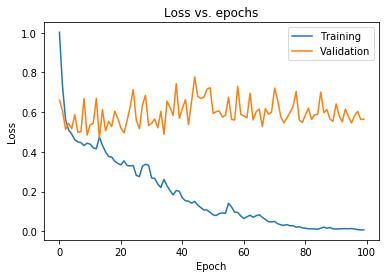

In [15]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [16]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [17]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_regularized_model(wd, rate):
    model = Sequential([
        Dense(1024, kernel_regularizer=regularizers.l2(wd), activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(rate),
        Dense(1024, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(512, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(512, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(256, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(256, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(1)
    ])
    return model

model = get_model()

In [18]:
# Re-build the model with weight decay and dropout layers

model = get_regularized_model(1e-5, 0.3)

In [19]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [20]:
# Train the model, with some of the data reserved for validation

history = model.fit(X_train, y_train, epochs=100, 
                    validation_split=.15, batch_size=64, verbose=False)

In [21]:
# Evaluate the model on the test set

model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.6653 - mae: 0.6156


[0.6507392777336969, 0.615614]

#### Plot the learning curves

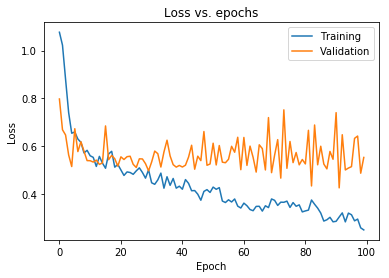

In [22]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [23]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("----------: Starting Training :----------")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"----------: Beginning Training of Epoch: {epoch} :------------")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"----------: Beginning Training of Batch: {batch} :-----------")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"----------: Finishing Training of Batch: {batch} :--------------")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"----------: Finishing Training of Epoch: {epoch} :-------------")
        
    def on_train_end(self, logs=None):
        print("----------: Finished Training :-----------")

In [24]:
# Re-build the model

model = get_regularized_model(1e-5, 0.3)

In [25]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [26]:
# Train the model, with some of the data reserved for validation

history = model.fit(X_train, y_train, epochs=3, batch_size=128, verbose=2, callbacks=[TrainingCallback()])

Train on 397 samples
----------: Starting Training :----------
----------: Beginning Training of Epoch: 0 :------------
Epoch 1/3
----------: Beginning Training of Batch: 0 :-----------
----------: Finishing Training of Batch: 0 :--------------
----------: Beginning Training of Batch: 1 :-----------
----------: Finishing Training of Batch: 1 :--------------
----------: Beginning Training of Batch: 2 :-----------
----------: Finishing Training of Batch: 2 :--------------
----------: Beginning Training of Batch: 3 :-----------
----------: Finishing Training of Batch: 3 :--------------
----------: Finishing Training of Epoch: 0 :-------------
397/397 - 3s - loss: 1.0387
----------: Beginning Training of Epoch: 1 :------------
Epoch 2/3
----------: Beginning Training of Batch: 0 :-----------
----------: Finishing Training of Batch: 0 :--------------
----------: Beginning Training of Batch: 1 :-----------
----------: Finishing Training of Batch: 1 :--------------
----------: Beginning Train

In [27]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("----------: Starting Testing :----------")
        
    
    def on_test_batch_begin(self, batch, logs=None):
        print(f"----------: Beginning Testing of Batch: {batch} :-----------")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"----------: Finishing Testing of Batch: {batch} :--------------")
        
        
    def on_test_end(self, logs=None):
        print("----------: Finished Training :-----------")

In [30]:
# Evaluate the model

model.evaluate(X_test, y_test, verbose=False, callbacks=[TestingCallback()])

----------: Starting Testing :----------
----------: Beginning Testing of Batch: 0 :-----------
----------: Finishing Testing of Batch: 0 :--------------
----------: Beginning Testing of Batch: 1 :-----------
----------: Finishing Testing of Batch: 1 :--------------
----------: Finished Training :-----------


0.6067142513063218

In [31]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("----------: Starting Prediction :----------")
        
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"----------: Beginning Prediction of Batch: {batch} :-----------")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"----------: Finishing Prediction of Batch: {batch} :--------------")
        
        
    def on_predict_end(self, logs=None):
        print("----------: Finished Predicting :-----------")

In [33]:
# Make predictions with the model

model.predict(X_test, verbose=False, callbacks=[PredictionCallback()])

----------: Starting Prediction :----------
----------: Beginning Prediction of Batch: 0 :-----------
----------: Finishing Prediction of Batch: 0 :--------------
----------: Beginning Prediction of Batch: 1 :-----------
----------: Finishing Prediction of Batch: 1 :--------------
----------: Finished Predicting :-----------


array([[-0.6882485 ],
       [-0.4802805 ],
       [-0.100226  ],
       [ 0.21707529],
       [-0.64035475],
       [-0.47801003],
       [ 0.129342  ],
       [-0.5910531 ],
       [-0.3628535 ],
       [ 0.2843802 ],
       [-0.194616  ],
       [-0.48985943],
       [-0.4583292 ],
       [-0.49123213],
       [ 0.29520988],
       [ 0.21973342],
       [ 0.01533273],
       [-0.5711976 ],
       [-0.40037346],
       [ 0.21464835],
       [ 0.27327284],
       [-0.08251259],
       [ 0.29468805],
       [-0.4652168 ],
       [-0.43288106],
       [ 0.20335278],
       [-0.4785858 ],
       [ 0.30550233],
       [-0.574668  ],
       [-0.692721  ],
       [-0.4713932 ],
       [ 0.22701328],
       [ 0.3082166 ],
       [ 0.2197731 ],
       [-0.44247875],
       [ 0.23814884],
       [-0.44923243],
       [ 0.26985136],
       [-0.63800985],
       [-0.39018244],
       [-0.28264093],
       [ 0.15486342],
       [ 0.24700509],
       [-0.6393979 ],
       [ 0.265622  ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [34]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer = 'adam', loss='mse')
unreg_history = unregularized_model.fit(X_train, y_train, epochs=100,
                                       validation_split = 0.15, batch_size=64, verbose=False,
                                       callbacks = [tf.keras.callbacks.EarlyStopping()])


In [35]:
# Evaluate the model on the test set

unregularized_model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.3915


0.37932883302370707

In [37]:
# Re-train the regularised model

regularized_model = get_regularized_model(1e-8, 0.2)
regularized_model.compile(optimizer = 'adam', loss='mse')
reg_history = regularized_model.fit(X_train, y_train, epochs=100,
                                       validation_split = 0.15, batch_size=64, verbose=False,
                                       callbacks = [tf.keras.callbacks.EarlyStopping()])

In [38]:
# Evaluate the model on the test set

regularized_model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.3215


0.35192826125356885

#### Plot the learning curves

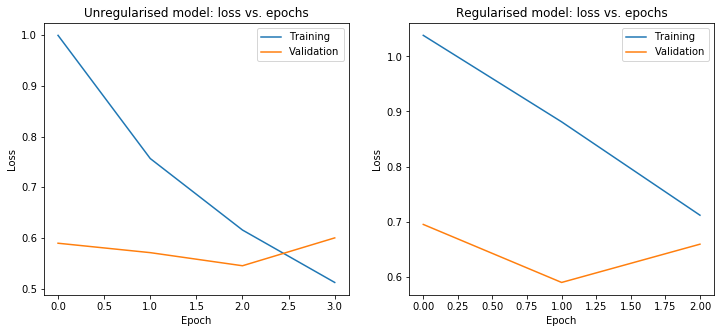

In [39]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

In [40]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer = 'adam', loss='mse')
unreg_history = unregularized_model.fit(X_train, y_train, epochs=100,
                                       validation_split = 0.15, batch_size=64, verbose=False,
                                       callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])


In [41]:
# Evaluate the model on the test set

unregularized_model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.5067


0.4444919957054986

In [42]:
# Re-train the regularised model

regularized_model = get_regularized_model(1e-8, 0.2)
regularized_model.compile(optimizer = 'adam', loss='mse')
reg_history = regularized_model.fit(X_train, y_train, epochs=100,
                                       validation_split = 0.15, batch_size=64, verbose=False,
                                       callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

In [43]:
# Evaluate the model on the test set

regularized_model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.3975


0.3540725668271383

#### Plot the learning curves

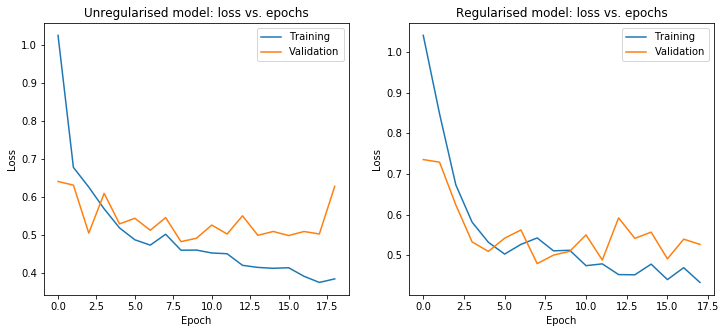

In [44]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

In [45]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer = 'adam', loss='mse')
unreg_history = unregularized_model.fit(X_train, y_train, epochs=100,
                                       validation_split = 0.15, batch_size=64, verbose=False,
                                       callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])


In [46]:
# Evaluate the model on the test set

unregularized_model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.4227


0.3927881485886044

In [47]:
# Re-train the regularised model

regularized_model = get_regularized_model(1e-8, 0.2)
regularized_model.compile(optimizer = 'adam', loss='mse')
reg_history = regularized_model.fit(X_train, y_train, epochs=100,
                                       validation_split = 0.15, batch_size=64, verbose=False,
                                       callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])

In [48]:
# Evaluate the model on the test set

regularized_model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.4105


0.40450636678271823

#### Plot the learning curves

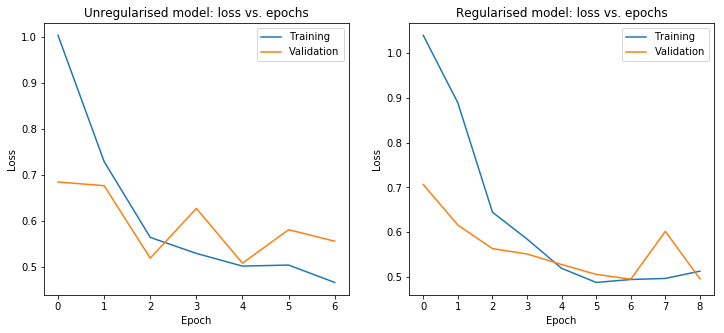

In [49]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()